# Exploratory analysis mice-tumor data
* **Objectives:** 
    1. Classify scan slices into tumor vs. no tumor classes 
    2. Segment the tumors (future work)
    
    
* **Methods:** 
    1. 2D convnets using TensorFlow
    
    
* **Validation:** 
    1. 10-fold CV (no nested innerloop yet for hyper-parameter tuning)
    

In [1]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import math
#import h5py as h5
#import SimpleITK as sitk
from sklearn.preprocessing import StandardScaler

#Data: http://repo.mouseimaging.ca/repo/for_Nikhil/

In [2]:
# Model Architecture Defs
#MLP
def build_model(X_,_dropout,node_sizes,net_type):
    if net_type == 'mlpnet':
        model = mlpnet(X_,_dropout,node_sizes)
    elif net_type == 'convnet':
        model = convnet(X_,_dropout,node_sizes)
    else: 
        print('unknown net architecture type')
    return model

def mlpnet(image,_dropout,node_sizes):
    l1 = mlp(image,node_sizes['input'],node_sizes['l1'],name='l1')
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = mlp(l1,node_sizes['l1'],node_sizes['l2'],name='l2')
    l2 = tf.nn.dropout(l2,1)
#     l3 = mlp(l2,node_sizes['l2'],node_sizes['l3'],name='l3')
#     l3 = tf.nn.dropout(l3,1)
    l4 = mlp(l2,node_sizes['l2'],node_sizes['output'],name='l4')
    return l4

def mlp(input_,input_dim,output_dim,name="mlp"):
    with tf.variable_scope(name):
        #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
        return tf.nn.tanh(tf.matmul(input_,w))
        #return tf.nn.relu(tf.matmul(input_,w))
    
#Convnet
def convnet(X_,_dropout,node_sizes):
    #image_dim = int(np.sqrt(node_sizes['input']))
    image_dim = node_sizes['input']
    final_image_vector_size = int(node_sizes['input'][0]*node_sizes['input'][1]/node_sizes['max_pool_redux_factor'])
    
    X_image = tf.reshape(X_, [-1,image_dim[0],image_dim[1],1])
    l1 = conv(X_image,node_sizes['kernel_dim'], 1, node_sizes['l1'], name='l1')  
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = conv(l1,node_sizes['kernel_dim'], node_sizes['l1'], node_sizes['l2'], name='l2')
    l2 = tf.nn.dropout(l2,_dropout)
    
    #reshape to vector (reduced image size*number of filters)
    l2_flat = tf.reshape(l2, [-1, final_image_vector_size*node_sizes['l2']])    
    l3 = mlp(l2_flat,final_image_vector_size*node_sizes['l2'],node_sizes['output'],name='mlp')    
    #l3 = tf.nn.dropout(l3,_dropout) #Doesnt work well
    return l3
    
def conv(input_, kernel_dim, in_channels, output_dim,name="conv"):
    with tf.variable_scope(name):
        W = tf.get_variable('w',[kernel_dim, kernel_dim, in_channels, output_dim],
                            tf.float32,tf.random_normal_initializer(mean = 0.01,stddev=0.02))
        b = tf.get_variable('b',[output_dim],tf.float32,tf.constant_initializer(0.1))                        
        h_conv = tf.nn.relu(conv2d(input_, W) + b)
        h_pool = max_pool_2x2(h_conv)
        return h_pool
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
def next_batch(s,e,inputs,labels):
    input1 = inputs[s:e]
    y = np.reshape(labels[s:e],(len(range(s,e)),2))
    return input1,y

def compute_accuracy(prediction,labels):
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return acc

# Extract 2D slices OR 1D labels from volumes 
def getSliceInfoFrom3DVolume(vol_list,slice_dim,label_slices):
    slicex = vol_list[0].shape[slice_dim]
    #slice_info_list = []
    for v,vol in enumerate(vol_list):
        sub_slices = np.split(vol,slicex,axis=slice_dim)
        sub_slices_vectorized = np.reshape(sub_slices,[-1,slicex])
        
        #If volume is a segmented image then count tumor voxels. 
        if label_slices:
            label_count = np.sum(sub_slices_vectorized,axis=0) > 0
            if v ==0:
                out_array = label_count
            else:
                out_array = np.concatenate((out_array,label_count))
        
        #Else just list 2D slices
        else:
            if v ==0:
                out_array = sub_slices_vectorized
            else:
                out_array = np.hstack((out_array,sub_slices_vectorized))
        
    return np.squeeze(out_array)

In [3]:
#Data imports (Separate loops for images with segmentations and images without segmentations)

baseline_dir = '/projects/nikhil/mice_tumors/'

image_label_pairs = {
"B3_M6_null_062615_HR_MUT_small.npy": "B3_M6_null_062615_HR_tumor_labels_small.npy",
"B3_C2_R_062215_HR_MUT_small.npy": "B3_C2_R_062215_HR_tumor_labels_small.npy", 
"B3_M7_LLR_062715_HR_MUT_small.npy": "B3_M7_LLR_062715_HR_tumor_labels_small.npy" ,
"B3_C5_LR_063015_HR_MUT_small.npy":"B3_C5_LR_063015_HR_tumor_labels_small.npy" , 
"B3_M7_LLR_070215_HR_MUT_small.npy":"B3_M7_LLR_070215_HR_tumor_labels_small.npy" ,
"B3_M3_LL_062315_HR_MUT_small.npy":"B3_M3_LL_062315_HR_tumor_labels_small.npy" , 
"B3_M8_LRR_062715_HR_MUT_small.npy":"B3_M8_LRR_062715_HR_tumor_labels_small.npy" ,
"B3_M4_RR_062615_HR_MUT_small.npy":"B3_M4_RR_062615_HR_tumor_labels_small.npy" ,
}

no_tumor_images = ["B10_C14_W3.hdr_WT_small.npy","B10_C2_021016_HR_W3.hdr_WT_small.npy",
"B10_C15_W3.hdr_WT_small.npy","B10_C3_021016_HR_W3.hdr_WT_small.npy","B10_C1_021016_HR_W3.hdr_WT_small.npy"]

sample_vol_img_list = []
sample_vol_label_list = []

for key in image_label_pairs.keys():
    sample_vol_img_file = '{}input_data/images/MUT/{}'.format(baseline_dir,key)
    sample_vol_label_file = '{}input_data/labels/{}'.format(baseline_dir,image_label_pairs[key])

    sample_vol_img = np.load(sample_vol_img_file)
    sample_vol_label = np.load(sample_vol_label_file)

    #Crop to square slices
    sample_vol_img = sample_vol_img[:24,:,:24]
    sample_vol_label = sample_vol_label[:24,:,:24]

    #List all files
    sample_vol_img_list.append(sample_vol_img)
    sample_vol_label_list.append(sample_vol_label)

print(len(sample_vol_img_list), len(sample_vol_label_list))
image = getSliceInfoFrom3DVolume(sample_vol_img_list,1,False).T
segs = getSliceInfoFrom3DVolume(sample_vol_label_list,1,False).T.astype(int)
labels = getSliceInfoFrom3DVolume(sample_vol_label_list,1,True)
print(image.shape, segs.shape, labels.shape)

sample_vol_img_list = []
for no_tumor in no_tumor_images:
    sample_vol_img_file = '{}input_data/images/no_tumor/{}'.format(baseline_dir,no_tumor)
    sample_vol_img = np.load(sample_vol_img_file)
    sample_vol_img = sample_vol_img[:24,:,:24]
    sample_vol_img_list.append(sample_vol_img)
    
print(len(sample_vol_img_list))
image_no_tumor = getSliceInfoFrom3DVolume(sample_vol_img_list,1,False).T
    
print(image_no_tumor.shape)

image = np.vstack((image,image_no_tumor))
labels = np.concatenate((labels,np.zeros(image_no_tumor.shape[0])))

print(image.shape, segs.shape, labels.shape)

8 8
(400, 576) (400, 576) (400,)
5
(250, 576)
(650, 576) (400, 576) (650,)


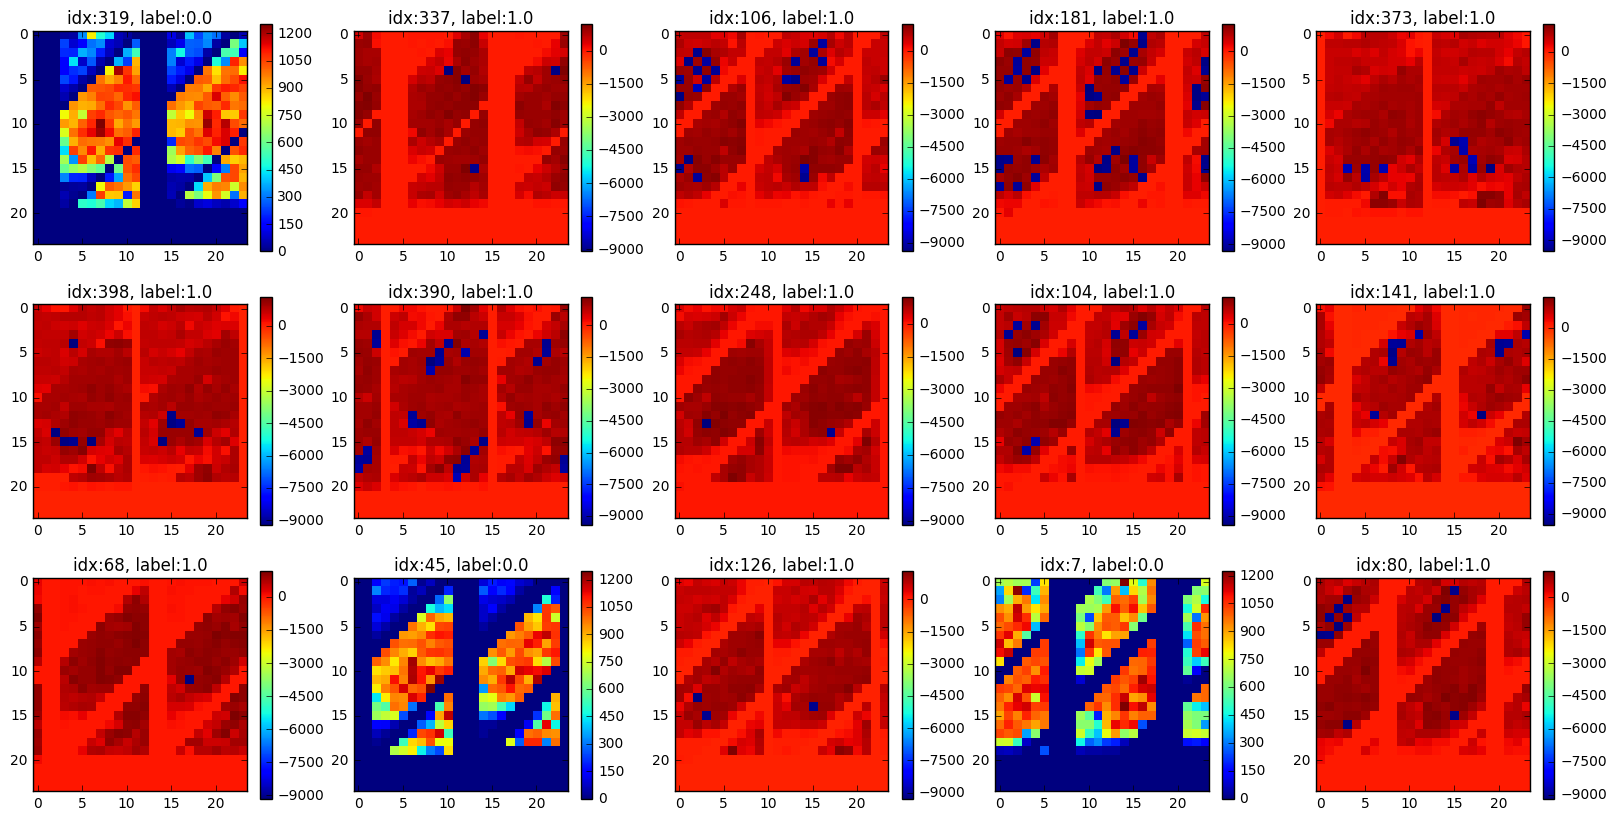

In [4]:
# plot sample image and label slices to visualize tumors in 2D slice
plt.figure(figsize=(20,10))
example_images = 15
mask_offset = 10000
for p, idx in enumerate(np.random.randint(0,segs.shape[0],example_images)):
    plt.subplot(example_images/5,5,p+1)
    plt.imshow(np.reshape(image[idx,:]-mask_offset*segs[idx,:],[24,24]),interpolation='nearest')
    plt.colorbar()
    plt.title('idx:{}, label:{}'.format(idx,labels[idx]))


In [5]:
# If KF doesn't exist then create train-val-test sets
# Currently simply doing 10 monte-carlo runs

n = image.shape[0]
d = image.shape[1]

foldx = 10

X_train_list = []
X_valid_list = []
X_test_list = []

y_train_list = []
y_valid_list = []
y_test_list = []

for fid in np.arange(foldx):
    #shuffle data
    idx = np.arange(n)
    np.random.shuffle(idx)
    X = image[idx,:]
    y_raw = labels[idx]

    #One-hot
    y = np.vstack((y_raw==True,y_raw==False)).T.astype(int)
    print(X.shape, y.shape)

    #split data
    n_train = int(0.8*n)
    n_val = int(0.1*n)

    X_train = X[:n_train]
    X_valid   = X[n_train:n_train+n_val]
    X_test  = X[n_train+n_val:]

    #Scale input data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    y_train = y[:n_train]
    y_valid   = y[n_train:n_train+n_val]
    y_test  = y[n_train+n_val:]

    print(fid)
    print('train','valid','test')
    print(len(y_train),len(y_valid),len(y_test))
    print(np.sum(y[:n_train,0]==1)/float(len(y_train)),np.sum(y[n_train:n_train+n_val,0]==1)/float(len(y_valid)),
          np.sum(y[n_train+n_val:,0]==1)/float(len(y_test)))
    print(np.sum(y[:n_train,0]==0)/float(len(y_train)),np.sum(y[n_train:n_train+n_val,0]==0)/float(len(y_valid)),
          np.sum(y[n_train+n_val:,0]==0)/float(len(y_test)))
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_valid_list.append(y_valid)
    y_test_list.append(y_test)
    

(650, 576) (650, 2)
0
train valid test
520 65 65
0.563461538462 0.615384615385 0.446153846154
0.436538461538 0.384615384615 0.553846153846
(650, 576) (650, 2)
1
train valid test
520 65 65
0.544230769231 0.630769230769 0.584615384615
0.455769230769 0.369230769231 0.415384615385
(650, 576) (650, 2)
2
train valid test
520 65 65
0.542307692308 0.615384615385 0.615384615385
0.457692307692 0.384615384615 0.384615384615
(650, 576) (650, 2)
3
train valid test
520 65 65
0.555769230769 0.569230769231 0.553846153846
0.444230769231 0.430769230769 0.446153846154
(650, 576) (650, 2)
4
train valid test
520 65 65
0.55 0.630769230769 0.538461538462
0.45 0.369230769231 0.461538461538
(650, 576) (650, 2)
5
train valid test
520 65 65
0.559615384615 0.6 0.492307692308
0.440384615385 0.4 0.507692307692
(650, 576) (650, 2)
6
train valid test
520 65 65
0.551923076923 0.615384615385 0.538461538462
0.448076923077 0.384615384615 0.461538461538
(650, 576) (650, 2)
7
train valid test
520 65 65
0.555769230769 0.523

# TensorFlow configs
    1. Running K-fold in a for loop (not parallel)
    2. Prints out average test acc at the end
    3. Using fixed TF architecture (no hyperparameter tuning)

In [ ]:
## Run TF

# Basic configs
batch_size = 100
num_epochs = 100
foldx = 10
lr = 0.0001
keep_p = 0.75

train_loss = []
train_acc = []
valid_acc = []
test_acc = []

test_fold_acc = []

for fid in range(foldx):  
    print(fid)
    X_train = X_train_list[fid]
    X_valid = X_valid_list[fid]
    X_test = X_test_list[fid]
    y_train = y_train_list[fid]
    y_valid = y_valid_list[fid]
    y_test = y_test_list[fid]
    node_sizes = {'input':[24,24],'l1':50,'l2':50,'l3':0,'output':2,'kernel_dim':5,'max_pool_redux_factor':16}
    with tf.Graph().as_default():    
        data = tf.placeholder(tf.float32,shape=([None,node_sizes['input'][0]*node_sizes['input'][1]]),name='input_data')        
        labels = tf.placeholder(tf.float32,shape=([None,2]),name='gt')                
        dropout_f = tf.placeholder("float")

        with tf.variable_scope("micenet") as scope:
            model1= build_model(data,dropout_f,node_sizes,'convnet')            
            
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model1,labels=labels))         
        acc = compute_accuracy(model1,labels)
        
#         t_vars = tf.trainable_variables()
#         d_vars  = [var for var in t_vars if 'l' in var.name]
#         batch = tf.Variable(0)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
        #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)

        # Launch the graph
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            #sess.run(init)
            tf.initialize_all_variables().run()
            # Training cycle
            for epoch in range(num_epochs):
                avg_loss = 0.
                avg_acc = 0.
                total_batch = int(X_train.shape[0]/batch_size)
                start_time = time.time()
                # Loop over all batches
                for i in range(total_batch):
                    s  = i * batch_size
                    e = (i+1) *batch_size
                    
                    # Fit training using batch data
                    tr_X,tr_y = next_batch(s,e,X_train,y_train)  
                    #print(input1.shape, y.shape)
                                
                    _,tr_loss,tr_acc=sess.run([optimizer,loss,acc], 
                                                  feed_dict={data:tr_X,labels:tr_y,dropout_f:keep_p})
                    
                    predict=model1.eval(feed_dict={data:tr_X,dropout_f:1.0})                    
                    tr_acc = compute_accuracy(predict,tr_y).eval()                
                                        
                    #print(tr_acc.eval())
#                     if math.isnan(tr_acc) and epoch != 0:
#                         print('tr_acc %0.2f' % tr_acc)
#                         pdb.set_trace()

                    avg_loss += tr_loss
                    avg_acc +=tr_acc*100
                                        
                #print('epoch %d loss %0.2f' %(epoch,avg_loss/total_batch))
                duration = time.time() - start_time
                #print('epoch %d  time: %f loss %0.5f acc %0.2f' %(epoch,duration,avg_loss/(total_batch),avg_acc/total_batch))
                train_loss.append(avg_loss/(total_batch))
                train_acc.append(avg_acc/total_batch)
                
                #Check performance on validation set                                                                                
                predict=model1.eval(feed_dict={data:X_valid,dropout_f:1.0})                
                va_acc = compute_accuracy(predict,y_valid).eval()*100.0
                valid_acc.append(va_acc)
                
                # Test model                                    
                predict= model1.eval(feed_dict={data:X_test,dropout_f:1.0})                
                te_acc = compute_accuracy(predict,y_test).eval()*100
                test_acc.append(te_acc)
                
                
                if epoch%10 == 0:
                    print('Accuracy validation set %0.2f' % ((va_acc)))

            #Accuracy of the entire training set at the end of training            
            predict= model1.eval(feed_dict={data:X_train, dropout_f:1.0})                
            tr_acc = compute_accuracy(predict,y_train).eval()*100
            print('Accuracy training set %0.2f' % (tr_acc))
            print('Accuracy validation set %0.2f' % (va_acc))


            # Test model                                    
            predict= model1.eval(feed_dict={data:X_test,dropout_f:1.0})                
            te_acc = compute_accuracy(predict,y_test)
            test_fold_acc.append(100 * te_acc.eval())
            print('Accuracy test set %0.4f' % (100 * te_acc.eval()))
        
print('')
print('test performance:{},{}'.format(np.mean(test_fold_acc),np.std(test_fold_acc)))

0
Accuracy validation set 38.46
Accuracy validation set 95.38
Accuracy validation set 95.38
Accuracy validation set 95.38
Accuracy validation set 95.38
Accuracy validation set 95.38
Accuracy validation set 95.38
Accuracy validation set 95.38
Accuracy validation set 95.38
Accuracy validation set 95.38
Accuracy training set 94.42
Accuracy validation set 95.38
Accuracy test set 90.7692
1
Accuracy validation set 36.92
Accuracy validation set 96.92
Accuracy validation set 96.92
Accuracy validation set 96.92
Accuracy validation set 96.92
Accuracy validation set 96.92
Accuracy validation set 96.92
Accuracy validation set 96.92
Accuracy validation set 96.92
Accuracy validation set 96.92
Accuracy training set 93.85
Accuracy validation set 96.92
Accuracy test set 93.8462
2
Accuracy validation set 64.62
Accuracy validation set 92.31
Accuracy validation set 92.31
Accuracy validation set 92.31
Accuracy validation set 92.31
Accuracy validation set 92.31
Accuracy validation set 92.31
Accuracy validat

In [20]:
print('')
print(test_fold_acc)
print('test performance:{},{}'.format(np.mean(test_fold_acc),np.std(test_fold_acc)))


[90.76923131942749, 93.84615421295166, 96.92307710647583, 95.384615659713745, 53.846156597137451, 96.92307710647583, 53.846156597137451, 95.384615659713745, 90.76923131942749, 95.384615659713745]
test performance:86.30769312381744,16.36058089264153


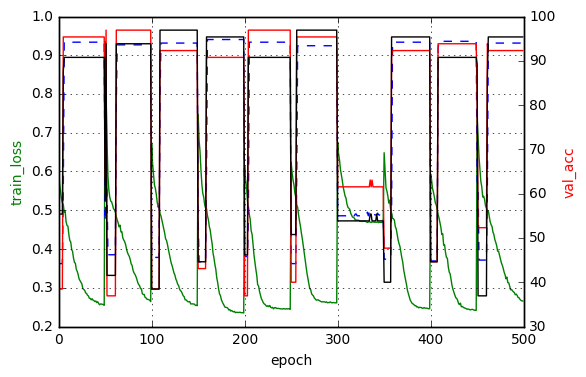

In [13]:
# Plot Acc and Loss
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_loss, 'g-')
ax2.plot(train_acc, 'b--')
ax2.plot(valid_acc, 'r-')
ax2.plot(test_acc, 'k-')


ax1.set_xlabel('epoch')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('val_acc', color='r')
ax1.grid()

(65, 2)


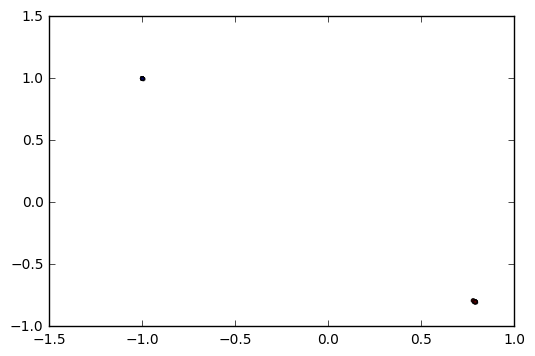

In [14]:
#Scatter plot of test predictions
plt.scatter(predict[:,0],predict[:,1],c=y_test[:,0],alpha=0.5,marker='.')

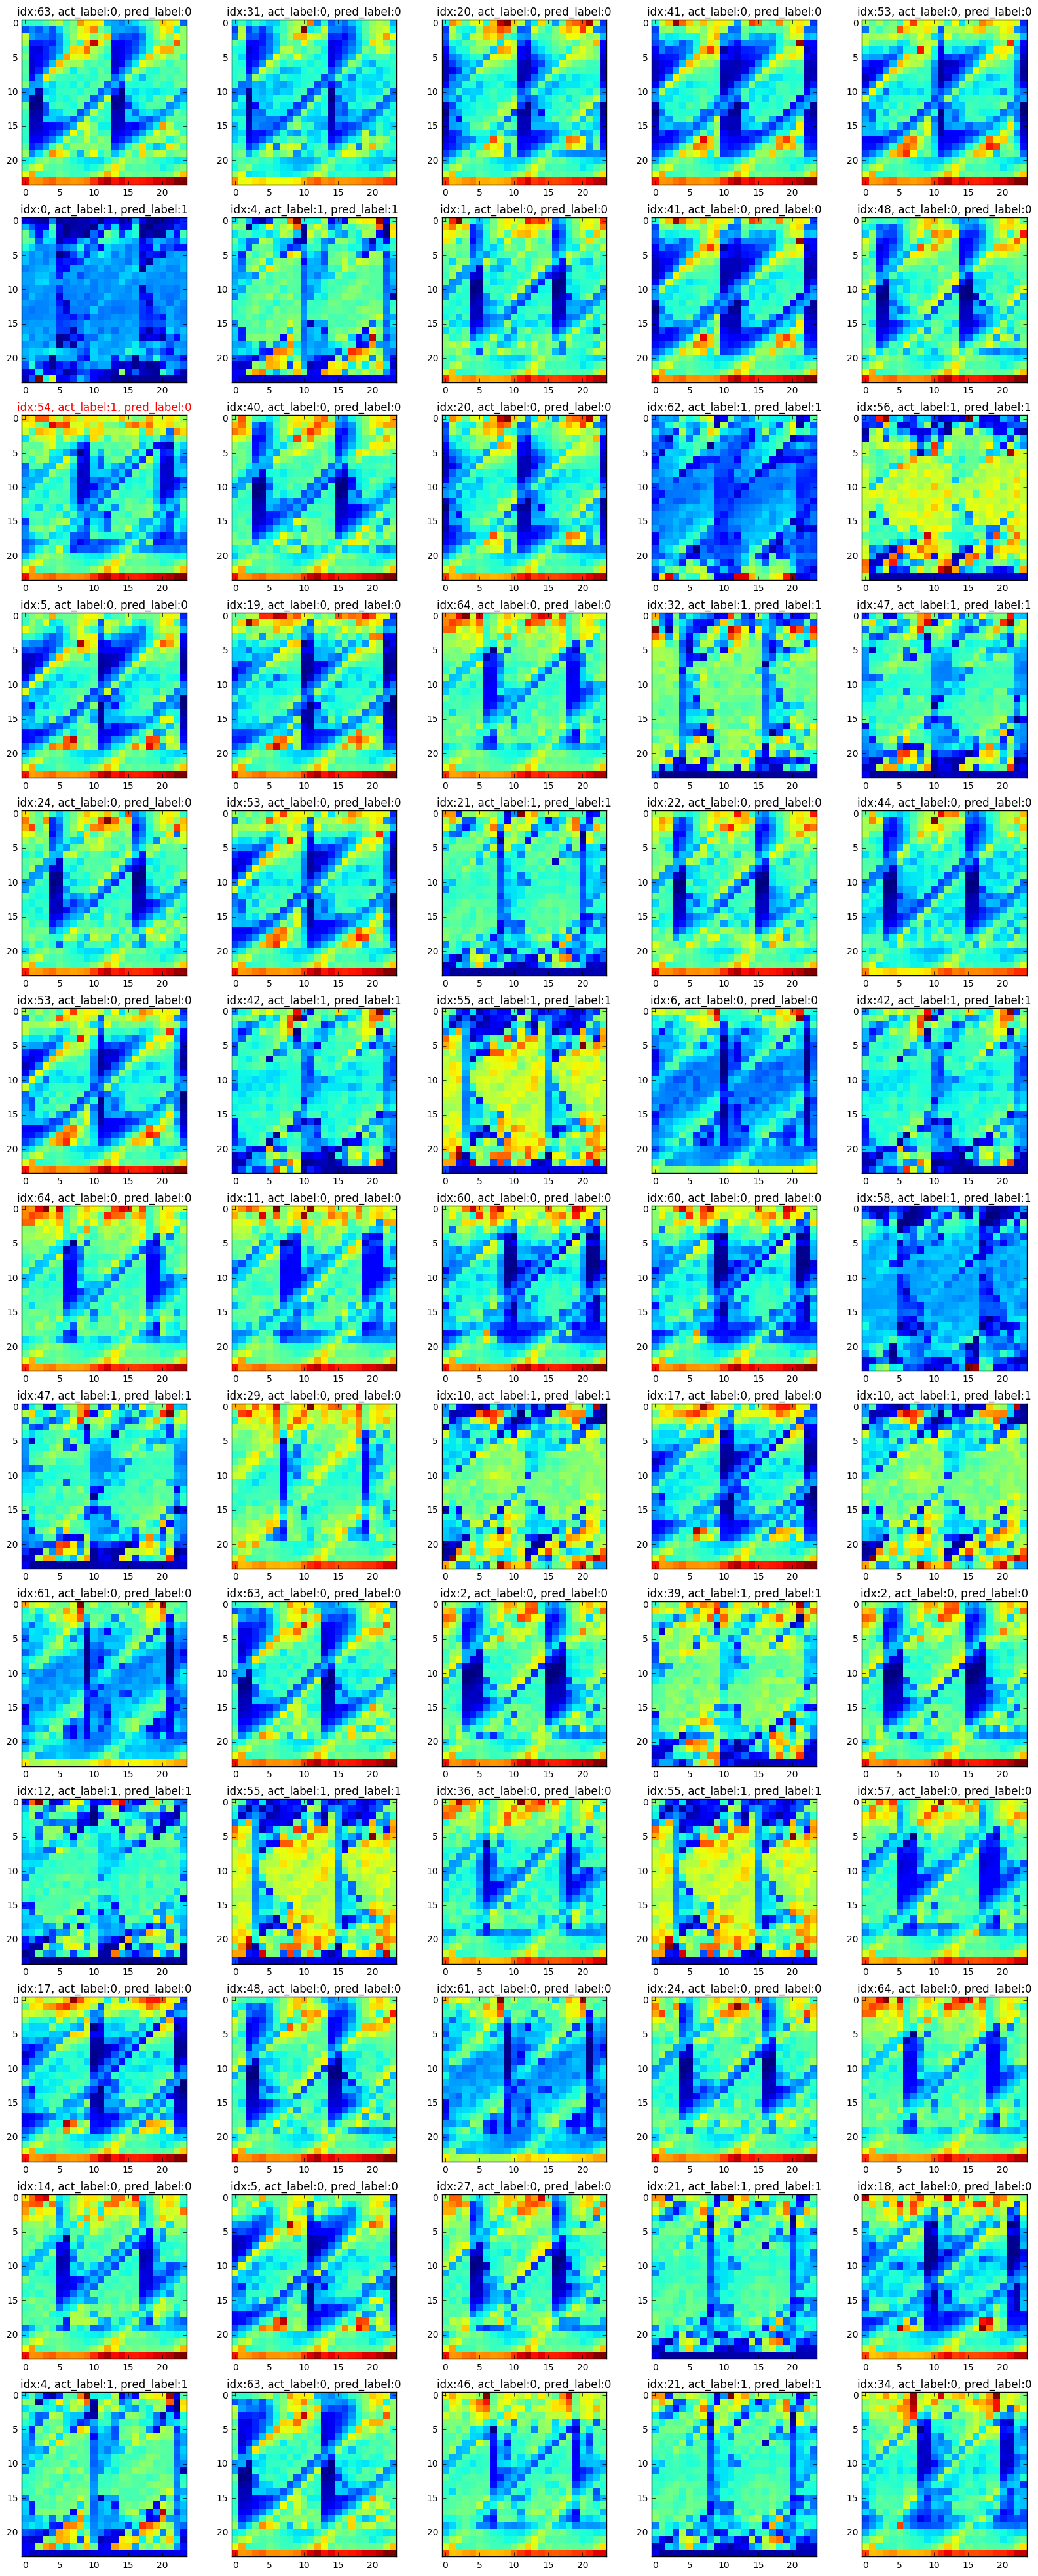

In [15]:
# Plot test images and predicted labels
# This will label wrong prediction titles in red

plt.figure(figsize=(20,50))
example_images = 65
for p, idx in enumerate(np.random.randint(0,X_test.shape[0],example_images)):
    plt.subplot(example_images/5,5,p+1)
    plt.imshow(np.reshape(X_test[idx,:],[24,24]),interpolation='nearest')
    #plt.colorbar()
    #print(y_test[idx,:],predict[idx,:])
    if np.argmax(y_test[idx,:])==np.argmax(predict[idx,:]):
        title_color = 'k'
    else:
        title_color = 'r'
        
    ax = plt.title('idx:{}, act_label:{}, pred_label:{}'.format(idx,np.argmax(y_test[idx,:]),np.argmax(predict[idx,:])))
    plt.setp(ax, color=title_color) 